<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "Chd7"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/Chd7/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


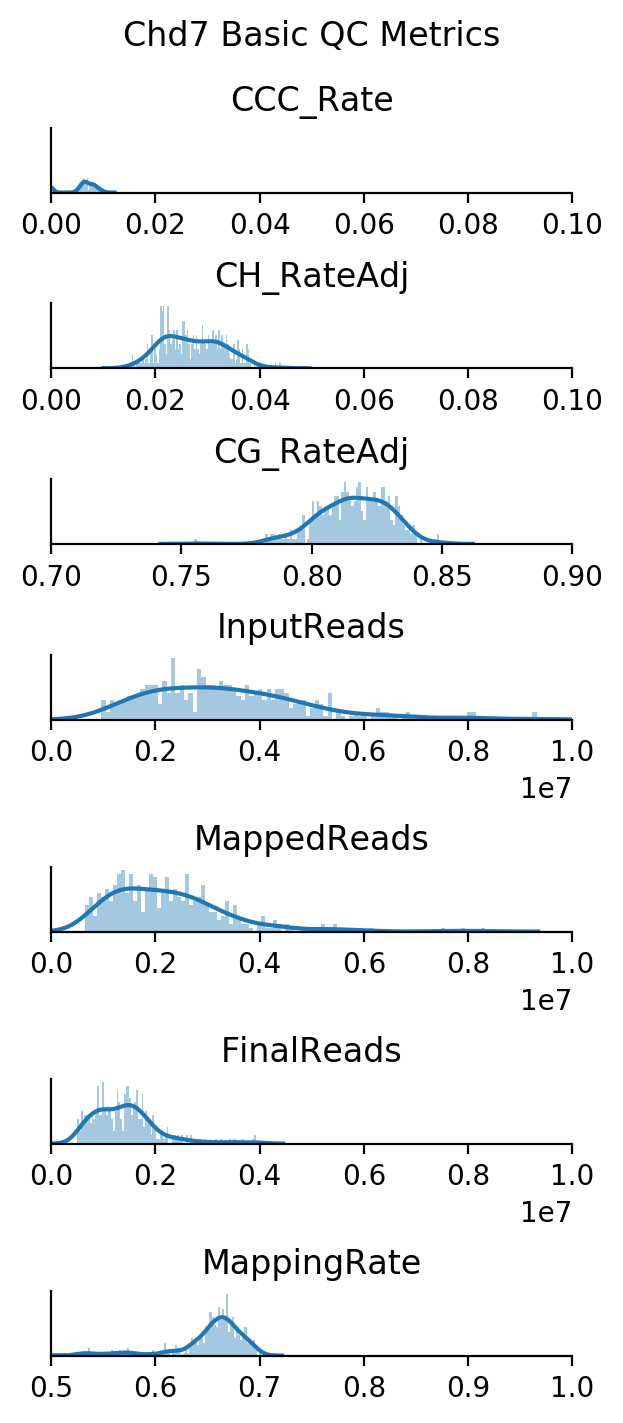

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

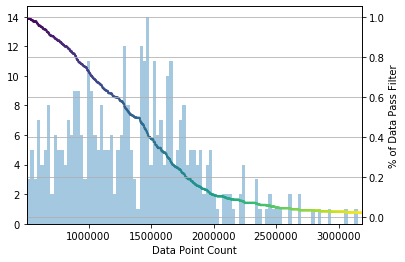

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 386/386 (100.0%)
CG_RateAdj passed 386/386 (100.0%)
CH_RateAdj passed 386/386 (100.0%)
FinalReads passed 386/386 (100.0%)
MappingRate passed 386/386 (100.0%)
Overall passed 386/386 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 33
171219 41
180109 25
180110 29
180111 12
180220 1
180222 1
180320 3
180329 2
180402 2
180405 25
180417 1
180724 2
180806 2
180911 6
180925 43
181008 1
181015 28
181016 29
181204 7
181206 41
181218 20
181220 27
190205 1
190207 4


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 38 9.9%
ad002 64 16.7%
ad004 40 10.4%
ad006 63 16.4%
ad007 38 9.9%
ad008 45 11.7%
ad010 54 14.1%
ad012 44 11.5%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
2E_M_1311,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.008080,0.850170,0.848950,0.043420,0.035630,739620.0,1911148,1165220.0,2E,...,5.417829,8.759621,7.693808,31.178035,Chd7,-13.947583,5.075143,2.631583,66.631803,True
2E_M_2078,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180222_2E...,0.004910,0.827620,0.826770,0.022590,0.017770,728542.0,1933672,1126991.0,2E,...,5.287263,6.942345,-17.676265,33.027175,Chd7,-12.454845,4.391596,6.498636,60.502275,True
3E_M_1140,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.006460,0.814860,0.813660,0.037040,0.030780,1548805.0,3436706,2410002.0,3E,...,6.231016,10.597308,9.224819,29.321019,Chd7,-14.219805,6.276108,0.729248,68.960226,True
3E_M_453,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.006600,0.824060,0.822890,0.034090,0.027670,1536496.0,3534590,2443897.0,3E,...,5.146866,7.587947,-18.270757,32.146746,Chd7,-13.133327,5.064318,6.133129,64.813772,True
3E_M_842,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.006970,0.817300,0.816020,0.038230,0.031480,1659110.0,3829422,2625294.0,3E,...,5.295761,8.826830,7.713959,31.133273,Chd7,-14.496861,5.356599,0.069735,65.528357,True
3F_M_1019,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.006420,0.815160,0.813970,0.027280,0.020990,680112.0,1816112,1017269.0,3F,...,5.380829,6.779711,-18.203170,31.262871,Chd7,-12.780234,4.344462,6.604177,62.404155,True
3F_M_1059,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180405_3F...,0.007870,0.822540,0.821130,0.041300,0.033700,1754249.0,4595318,2709033.0,3F,...,5.242742,8.984006,7.850712,30.980884,Chd7,-14.512754,5.618726,0.131359,65.924854,True
3F_M_1080,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180405_3F...,0.008750,0.802880,0.801140,0.044760,0.036330,583134.0,1159586,761720.0,3F,...,5.273623,9.363338,8.067176,30.768269,Chd7,-14.244656,6.000511,0.669185,67.292437,True
3F_M_1110,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180405_3F...,0.006920,0.831170,0.829990,0.032770,0.026030,536948.0,1124972,726501.0,3F,...,5.113711,6.861520,-18.303229,31.332671,Chd7,-12.559023,4.378885,8.359706,63.383062,True
